# HistoMIL Preprocessing Notebook

This Jupyter notebook is designed to guide users through the process of performing various preprocessing steps on histopathology whole-slide images using HistoMIL. This includes tissue segmentation, patching (tiling), and feature extraction. All preprocessing steps will be performed in batch. Predefined preprocessing parameters can be found in the HistoMIL package and can be modified in this notebook.

Additionally, this notebook will demonstrate how to perform preprocessing steps on a single slide file.

## Getting Started

Before proceeding with this notebook, please make sure that you have followed the setup instructions provided in the project's README file. This includes creating a conda environment and installing the required dependencies.

## Batch Preprocessing

The batch preprocessing pipeline in HistoMIL consists of the following steps:

Tissue segmentation
Patching (tiling)
Feature extraction
The default preprocessing parameters can be found in the HistoMIL/EXP/paras/slides.py file. You can modify these parameters to customize the preprocessing pipeline for your specific needs.

To perform batch preprocessing, you can use the cohort_slide_preprocessing function in the Experiment.cohort_slide_preprocessing module (HistoMIL.EXP.workspace.experiment.Experiment). Here's an example of how to run batch pre-processing:

In [1]:
%load_ext autoreload
%autoreload 2

# Set HistoMIL in PATH or change directory to where HistoMIL is

In [2]:
import os
os.getcwd()
os.chdir('/Users/awxlong/Desktop/my-studies/hpc_exps/') # 'path/to/ parent dir of HistoMIL'

In [3]:
# avoid pandas warning
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
# avoid multiprocessing problem
import torch
torch.multiprocessing.set_sharing_strategy('file_system')

#------>stop skimage warning
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
import imageio.core.util
import skimage 
def ignore_warnings(*args, **kwargs):
    pass
imageio.core.util._precision_warn = ignore_warnings

#set logger as INFO
from HistoMIL import logger
import logging
logger.setLevel(logging.INFO)

import pickle
import timm
import csv
from huggingface_hub import login


/Users/awxlong/anaconda3/envs/biomedai/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
from HistoMIL.EXP.paras.env import EnvParas
from HistoMIL.EXP.workspace.experiment import Experiment
from HistoMIL import logger
import logging
logger.setLevel(logging.INFO)

In [5]:
#--------------------------> parameters for reading data

preprocess_env = EnvParas()
preprocess_env.exp_name = "wandb exp name"      # e.g. "debug_preprocess"
preprocess_env.project = "wandb project name"   # e.g. "test-project" 
preprocess_env.entity =  "wandb entity name"    # make sure it's initialized to an existing wandb entity

#----------------> cohort
# you can find more options in HistoMIL/EXP/paras/cohort.py
preprocess_env.cohort_para.localcohort_name = "CRC" # cohort name, e.g. 'BRCA'
preprocess_env.cohort_para.task_name = "g0_arrest"     # biomarker name, e.g., 'g0_arrest' and HAS TO COINCIDE with column name
preprocess_env.cohort_para.cohort_file = f'local_cohort_{preprocess_env.cohort_para.localcohort_name}.csv' # e.g. local_cohort_BRCA.csv, this is created automatically, and contains folder, filename, slide_nb, tissue_nb, etc. 
preprocess_env.cohort_para.task_file = f'{preprocess_env.cohort_para.localcohort_name}_{preprocess_env.cohort_para.task_name}.csv' # e.g. BRCA_g0_arrest.csv, which has PatientID matched with g0_arrest labels. This is SUPPLIED by the user and assumed to be stored in the EXP/Data/ directory
preprocess_env.cohort_para.pid_name = "PatientID"           # default column for merging tables
preprocess_env.cohort_para.targets = ['g0_arrest']  # ['name of target_label column'] e.g.  ["g0_arrest"]  # the column name of interest # supply as a list of biomarkers
preprocess_env.cohort_para.targets_idx = 0                  
preprocess_env.cohort_para.label_dict = {0:0,1:1}  # SINGLE quotations for the keys, converts strings objects to binary values
# preprocess_env.cohort_para.task_additional_idx = ["g0_score"] # if CRC_g0_arrest.csv has other biomarkers of interest, name them in this variable, default None. 


## write a sample task cohort file

In [6]:
need_sample_task_cohort_file = False
if need_sample_task_cohort_file:
    # Input and output file names
    input_file = '/Users/awxlong/Desktop/my-studies/hpc_exps/HistoMIL/gdc_manifest.2024-06-18.txt' # path to the manifest.txt file which has filenames of diagnostic slides downloaded from TCGA
    output_file = f'/Users/awxlong/Desktop/my-studies/hpc_exps/Data/{preprocess_env.cohort_para.task_file}' # path to Data/ dir inside the experiment directory where these cohort .csv files are stored 
    # Read the input file and process the filenames
    with open(input_file, 'r') as infile, open(output_file, 'w', newline='') as outfile:
        reader = csv.reader(infile, delimiter='\t')  # Assuming tab-separated values
        writer = csv.writer(outfile)
        
        # Write header to the output file
        writer.writerow([preprocess_env.cohort_para.pid_name, preprocess_env.cohort_para.task_name])
        
        # Skip the header row of the input file
        next(reader)
        
        # Process each row
        for row in reader:
            if len(row) >= 3:  # Ensure the row has at least 3 columns
                filename = row[1]  # The filename is in the third column (index 2)
                index = filename[:12]  # Take the first 12 characters as the index
                even_odd = 'positive' if int(row[3])%2 == 0 else 'negative'
                writer.writerow([index, even_odd])
                
    print(f"Processing complete. Output saved to {output_file}")


In [7]:
def get_available_device():
    if torch.cuda.is_available():
        return "cuda"
    elif torch.backends.mps.is_available():
        return "mps"
    else:
        return "cpu"

device = get_available_device()

In [8]:
# #----------------> model specifications for preprocessing
# slide-level parameters
print(preprocess_env.collector_para.slide)

# tissue-level parameters
print(preprocess_env.collector_para.tissue)

# patch-level parameters
preprocess_env.collector_para.patch.step_size = 224 # int('your step size for patching') # e.g. 224 # ASSUME this also decides the size of patch, although you can change this
preprocess_env.collector_para.patch.patch_size = (224, 224) #(int('your step size for patching'), int('your step size for patching')) # can change this, default is 512, 512
print(preprocess_env.collector_para.patch)

# feature-extraction parameters
# by default uses resnet18

BACKBONES = {
    'uni': {
        'model_name': "hf_hub:MahmoodLab/UNI",
        'init_values': 1e-5,
        'dynamic_img_size': True
    },
    'prov-gigapath': {
        'model_name': "hf_hub:prov-gigapath/prov-gigapath"
    }
}

def create_model_from_backbones(model_key):
    model_config = BACKBONES.get(model_key)
    if not model_config:
        raise ValueError(f"Model {model_key} not found in available BACKBONES.")
    
    model_name = model_config.pop('model_name')
    model = timm.create_model(model_name, pretrained=True, **model_config)
    return model

backbone_name = 'prov-gigapath' # 'name of feature extractor, e.g. prov-gigapath. If none, by default HistoMIL uses resnet18'
if backbone_name:
    preprocess_env.collector_para.feature.model_name = backbone_name               # e.g. 'prov-gigapath'
    preprocess_env.collector_para.feature.model_instance = create_model_from_backbones(backbone_name) # timm.create_model("hf_hub:prov-gigapath/prov-gigapath", pretrained=True)
    preprocess_env.collector_para.feature.img_size = (224, 224)
    preprocess_env.collector_para.feature.out_dim = 1536
    preprocess_env.collector_para.feature.model_instance.to(device)
    
print(preprocess_env.collector_para.feature)

    

SlideParas(folder=None, fname=None)
TissueParas(seg_level=0, min_seg_level=None, ref_patch_size=256, mthresh=7, use_otsu=True, sthresh=8, sthresh_up=255, close=0, filter_params={'a_t': 100, 'a_h': 16, 'max_n_holes': 8}, to_contours=True, exclude_ids=[], keep_ids=[], name='tissue_0_otsu_True_contours_True')
PatchParas(patch_level=0, step_size=224, from_contours=True, mp_processor=1, contour_fn_name='four_pt', use_padding=True, name='patch(0)_size(512)_step(512)_contours(four_pt)')
FeatureParas(model_name='prov-gigapath', device='mps', trans=<function only_naive_transforms at 0x358ec4e50>, batch_size=32, cluster_nb=200, with_semantic_shifts=False)


In [9]:
device

'mps'

In [10]:

#----------------> dataset -- > not sure what this is 
preprocess_env.dataset_para.dataset_name = 'g0_arrest' # e.g. "DNAD_L2"
preprocess_env.dataset_para.concepts = ['slide', 'tissue', 'patch', 'feature'] # 'concepts you want to use'    # default ['slide', 'tissue', 'patch', 'feature'] in this ORDER
preprocess_env.dataset_para.split_ratio = [0.9, 0.1] # 'split ratio which sum to one'   # e.g [0.99,0.01]

In [11]:
#--------------------------> init machine and person by reading pkl file from notebook 0

machine_cohort_loc =  '/Users/awxlong/Desktop/my-studies/hpc_exps/User/CRC_machine_config.pkl' #"Path/to/BRCA_machine_config.pkl"
with open(machine_cohort_loc, "rb") as f:   # Unpickling
    [data_locs,exp_locs,machine,user] = pickle.load(f)
preprocess_env.data_locs = data_locs
preprocess_env.exp_locs = exp_locs

In [12]:

# #--------------------------> setup experiment for preprocessing (no ssl)
# logger.info("setup experiment")
# from HistoMIL.EXP.workspace.experiment import Experiment
# exp = Experiment(env_paras=preprocess_env)
# exp.setup_machine(machine=machine,user=user)
# logger.info("setup data")
# exp.init_cohort()                   # This will create 2 files inside EXP/Data/: local_cohort_BRCA.csv which has filenames of WSIs stored in TCGA-BRCA/ and Task_g0_arrest.csv which merges the local_cohort_BRCA.csv with the supplied BRCA_g0_arrest.csv
# logger.info("pre-processing..")
# exp.cohort_slide_preprocessing(concepts=["slide","tissue","patch"],
#                                 is_fast=True, force_calc=True)

## Single Slide Preprocessing

If you want to perform preprocessing steps on a single slide file, you can use the preprocess_slide function in the HistoMIL.DATA.Slide.collector.pre_process_wsi_collector  function. Here's how we define this function and an example of how to use this function:

HistoMIL - INFO - TissuePara:: set min_seg_level to 2,in [(80896, 105472), (20224, 26368), (5056, 6592)] 


> /Users/awxlong/Desktop/my-studies/hpc_exps/HistoMIL/DATA/Slide/concepts/feature.py(319)__getitem__()
    316                                  patch_size = self.patch_size,
    317                                   patch_level = self.patch_level)
    318         pdb.set_trace()
--> 319         img = self._processing(img)
    320         return img



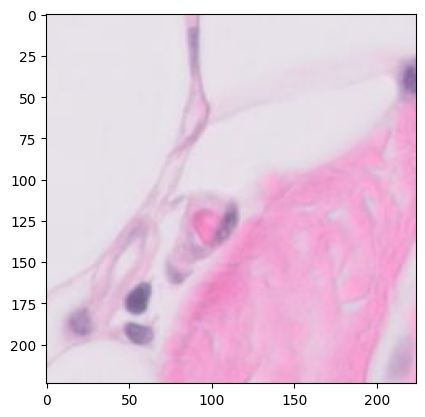

> /Users/awxlong/Desktop/my-studies/hpc_exps/HistoMIL/DATA/Slide/concepts/feature.py(319)__getitem__()
    316                                  patch_size = self.patch_size,
    317                                   patch_level = self.patch_level)
    318         pdb.set_trace()
--> 319         img = self._processing(img)
    320         return img

> /Users/awxlong/Desktop/my-studies/hpc_exps/HistoMIL/DATA/Slide/concepts/feature.py(319)__getitem__()
    316                                  patch_size = self.patch_size,
    317                                   patch_level = self.patch_level)
    318         pdb.set_trace()
--> 319         img = self._processing(img)
    320         return img

> /Users/awxlong/Desktop/my-studies/hpc_exps/HistoMIL/DATA/Slide/concepts/feature.py(319)__getitem__()
    316                                  patch_size = self.patch_size,
    317                                   patch_level = self.patch_level)
    318         pdb.set_trace()
--> 319         

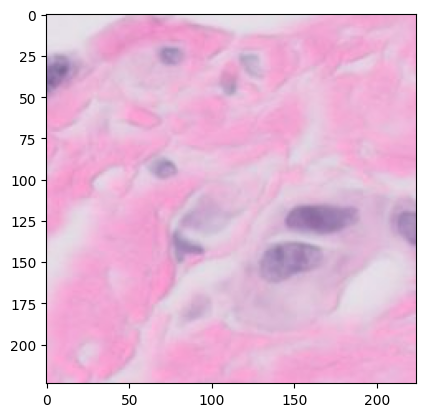

HistoMIL - ERROR - 
Traceback (most recent call last):
  File "/var/folders/5g/t9d5_kvd3kb4yljp4f0pvqqc0000gn/T/ipykernel_4714/838862134.py", line 23, in pre_process_wsi_collector
    C.get(name, force_calc) # for tissue, req_idx_0 is always default slide
  File "/Users/awxlong/Desktop/my-studies/hpc_exps/HistoMIL/DATA/Slide/collector/data_collector.py", line 139, in get
    self.feature.get(self.slide,self.patch,force_calc=force_calc)
  File "/Users/awxlong/Desktop/my-studies/hpc_exps/HistoMIL/DATA/Slide/concepts/feature.py", line 124, in get
    self.calc(slide=slide,
  File "/Users/awxlong/Desktop/my-studies/hpc_exps/HistoMIL/DATA/Slide/concepts/feature.py", line 94, in calc
    self.extractor.process(slide=slide,patches=patches)
  File "/Users/awxlong/Desktop/my-studies/hpc_exps/HistoMIL/DATA/Slide/concepts/feature.py", line 172, in process
    for i, x in enumerate(self.dataloader, 0):
  File "/Users/awxlong/anaconda3/envs/biomedai/lib/python3.9/site-packages/torch/utils/data/data

In [13]:
from pathlib import Path
# from HistoMIL.DATA.Slide.collector import WSICollector,CollectorParas
from HistoMIL.EXP.paras.slides import DEFAULT_CONCEPT_PARAS, CollectorParas

from HistoMIL.DATA.Slide.collector.data_collector import WSICollector
from HistoMIL.EXP.paras.slides import DEFAULT_CONCEPT_PARAS
def pre_process_wsi_collector(data_locs,
                            wsi_loc:Path,
                            collector_paras:CollectorParas,
                            concepts:list=["slide","tissue","patch"],
                            fast_process:bool=True,force_calc:bool=False):

    C = WSICollector(db_loc=data_locs,wsi_loc=wsi_loc,paras=collector_paras)
    try:

        for name in concepts:
            if name == "tissue":
                if fast_process:
                    from HistoMIL.EXP.paras.slides import set_min_seg_level
                    C.paras.tissue = set_min_seg_level(C.paras.tissue, C.slide,C.paras.tissue.min_seg_level)
                    logger.debug(f"Collector:: set seg level to {C.paras.tissue.seg_level}")
            C.create(name)
            C.get(name, force_calc) # for tissue, req_idx_0 is always default slide
    except Exception as e:
        logger.exception(e)
    else:
        logger.info(f"Collector:: {wsi_loc} is done")
    finally:
        del C

# folder = "folder of wsi/"
# fname =  "name of wsi.svs"
wsi_loc = Path("tcga_folder_3/TCGA-A8-A086-01Z-00-DX1.2B52D1B8-5AD4-4BD6-ADF7-9D65B8EE2623.svs")# Path(str("/"+ folder +"/"+ fname))
wsi_loc = Path("tiff_folder_1/TCGA-3C-IRUJ-01A-01-BS1.c5948da8-a676-4cbf-819c-b636c968cf46_luba.tiff")
# wsi_loc = Path("tiff_folder_2/2_TCGA-3C-JPPQ-01A-01-BS1.c5948da8-a676-4cbf-819c-b636c968cf46.tiff")
pre_process_wsi_collector(data_locs,
                            wsi_loc,
                            concepts=["slide","tissue","patch", "feature"],
                            collector_paras=DEFAULT_CONCEPT_PARAS,
                            )

In [14]:
import matplotlib.pyplot as plt

In [14]:
test = torch.load('/Users/awxlong/Desktop/my-studies/temp_data/CRC/Feature/prov-gigapath/tiff_folder_2.2_TCGA-3C-JPPQ-01A-01-BS1.c5948da8-a676-4cbf-819c-b636c968cf46.tiff.pt')
print(test.shape)
test

torch.Size([9778, 1536])


tensor([[ 0.0044, -0.3737,  0.5650,  ..., -1.2576, -1.0004,  0.6982],
        [ 0.5649, -0.3892, -0.1404,  ...,  0.4064,  0.2445, -0.6250],
        [ 0.1539, -0.6189, -0.0150,  ...,  0.6304,  0.2460, -0.1367],
        ...,
        [-0.3877, -1.4844, -0.0139,  ..., -0.6301, -2.1226, -0.3942],
        [-0.9896, -0.9584, -0.2310,  ..., -1.2595, -1.4528,  0.4127],
        [-1.4366, -0.8157, -0.8522,  ...,  0.4713, -1.4024, -0.2962]])

In [ ]:
test2 = torch.load('/Users/awxlong/Desktop/my-studies/temp_data/CRC/ca1f5e9c-2943-4cfd-829b-ad7713f49fa0.TCGA-AR-A0TU-01Z-00-DX1.2CBBDDAB-C1DD-4205-A555-431542F9C069.svs.pt')
print(test2.shape)
test2